# XGBoost Classifier
**4.0 XGBoost classifier** This trains a XGBoost classifier using High Level Features. It performs well in terms of speed and accuracy.

To run this notebook we used the following configuration:
* *Software stack*: Spark 2.4.3
* *Platform*: CentOS 7, Python 3.6
* *Spark cluster*: Analytix

In [1]:
# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-2.4.3-bin-hadoop2.7') #set path to SPARK_HOME

In [2]:
# Configure according to your environment
from pyspark.sql import SparkSession


xgboost_jars_location="/home/luca/XGBoost/ml.dmlc_xgboost4j-0.82.jar,/home/luca/XGBoost/ml.dmlc_xgboost4j-spark-0.82.jar"

spark = SparkSession.builder \
        .appName("Training-XGBoostClassifier") \
        .master("yarn") \
        .config("spark.driver.memory","14g") \
        .config("spark.executor.memory","14g") \
        .config("spark.executor.cores","16") \
        .config("spark.executor.instances","1") \
        .config("spark.dynamicAllocation.enabled","false") \
        .config("spark.speculation","false") \
        .config("spark.jars",xgboost_jars_location) \
        .getOrCreate()

In [3]:
spark

In [4]:
# Add a file containing wrapper functions for XGBoost
xgboost_python_wrapper="/home/luca/XGBoost/sparkxgb.zip"
spark.sparkContext.addPyFile(xgboost_python_wrapper)

## Load train and test dataframes

In [5]:
PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"
# PATH = "/project/ML/data/swan/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['hfeatures', 'label', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['hfeatures', 'label', 'encoded_label'])

In [6]:
# Optionally count the number of events in the training and test datasets
print('There are', trainDF.count(), 'training events')
print('There are', testDF.count(), 'test events')

There are 3426083 training events
There are 856090 test events


In [7]:
trainDF.printSchema()

root
 |-- hfeatures: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- encoded_label: vector (nullable = true)



In [8]:
testDF.show(3)

+--------------------+-----+-------------+
|           hfeatures|label|encoded_label|
+--------------------+-----+-------------+
|[74.9491729736328...|    0|(3,[0],[1.0])|
|[0.0,27.335390090...|    0|(3,[0],[1.0])|
|[47.6835403442382...|    0|(3,[0],[1.0])|
+--------------------+-----+-------------+
only showing top 3 rows



## Train XGBoost

In [9]:
from sparkxgb.xgboost import XGBoostClassifier

xgboost = XGBoostClassifier(objective="multi:softprob", numClass=3,
                            featuresCol="hfeatures", \
                            labelCol="label", \
                            predictionCol="prediction")

In [11]:
%time xgboost_model = xgboost.fit(trainDF)

CPU times: user 25.7 ms, sys: 17.5 ms, total: 43.3 ms
Wall time: 1min 50s


## Save the model

In [12]:
# does not seem to work in current version
# xgboost_model.save("file:/tmp/models/XGBoost/xgboost_model")

In [13]:
# reload with:
# from sparkxgb.xgboost import XGBoostClassifier
# xgboost_model = XGBoostClassifier.load('file:/tmp/models/XGBoost/xgboost_model')

## Prediction

In [14]:
pred = xgboost_model.transform(testDF)

In [15]:
pred.show(5)

+--------------------+-----+-------------+--------------------+--------------------+----------+
|           hfeatures|label|encoded_label|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+--------------------+----------+
|[74.9491729736328...|    0|(3,[0],[1.0])|[0.90797317028045...|[0.47847616672515...|       0.0|
|[0.0,27.335390090...|    0|(3,[0],[1.0])|[0.84627085924148...|[0.46043124794960...|       0.0|
|[47.6835403442382...|    0|(3,[0],[1.0])|[0.91938078403472...|[0.48010170459747...|       0.0|
|[80.9036312103271...|    0|(3,[0],[1.0])|[0.84627085924148...|[0.45932754874229...|       0.0|
|[95.2762756347656...|    0|(3,[0],[1.0])|[0.93674862384796...|[0.49031746387481...|       0.0|
+--------------------+-----+-------------+--------------------+--------------------+----------+
only showing top 5 rows



## Compute the AUC

In [16]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('probability').alias('probability')])

In [17]:
%time pred_pd = pred.select(['encoded_label', 'probability']).toPandas()

CPU times: user 3.64 s, sys: 263 ms, total: 3.9 s
Wall time: 35.1 s


In [18]:
pred_pd.head()

,encoded_label,probability
0,"[1.0, 0.0, 0.0]","[0.4784761667251587, 0.26271122694015503, 0.25..."
1,"[1.0, 0.0, 0.0]","[0.4604312479496002, 0.2621181309223175, 0.277..."
2,"[1.0, 0.0, 0.0]","[0.48010170459747314, 0.26061373949050903, 0.2..."
3,"[1.0, 0.0, 0.0]","[0.4593275487422943, 0.2682487964630127, 0.272..."
4,"[1.0, 0.0, 0.0]","[0.4903174638748169, 0.2561989724636078, 0.253..."


In [19]:
import numpy as np
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['probability'].tolist())

In [20]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


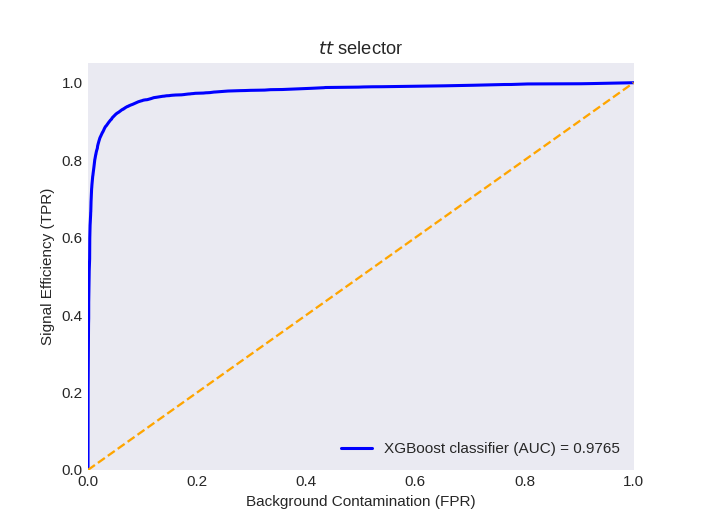

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue', 
         lw=2, label='XGBoost classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


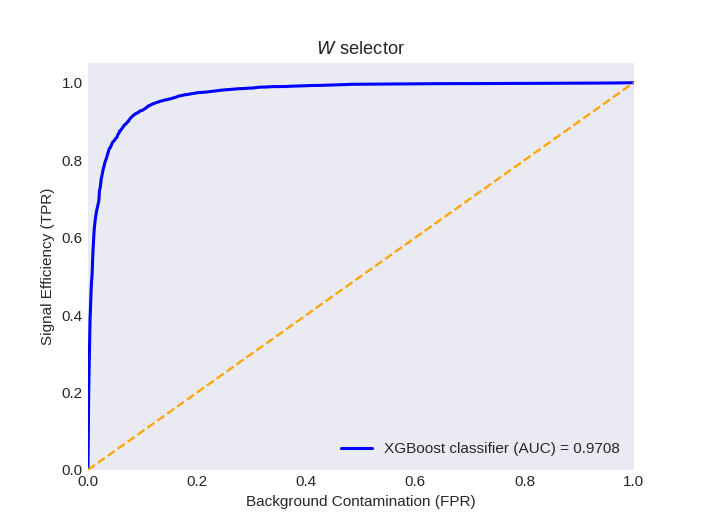

In [19]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='blue', 
         lw=2, label='XGBoost classifier (AUC) = %0.4f' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Confusion Matrix

In [22]:
from sklearn.metrics import accuracy_score

print('Accuracy of the XGBoost classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the XGBoost classifier: 0.8932


<IPython.core.display.Javascript object>


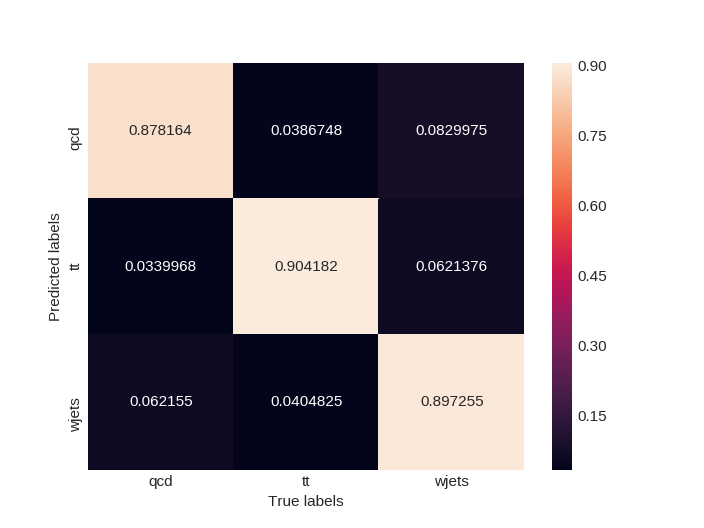

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [29]:
spark.stop()